# Async Streams

C# 8.0 introduces async streams. They provide a natural programming model for asynchronous streaming data sources.

Async streams rely on new interfaces introduced in .NET Standard 2.1.
```csharp
public interface IAsyncEnumerable<out T>
{
    IAsyncEnumerator<T> GetAsyncEnumerator(CancellationToken cancellationToken = default);
}
public interface IAsyncEnumerator<out T> : IAsyncDisposable
{
    ValueTask<bool> MoveNextAsync();

    T Current { get; }
}
public interface IAsyncDisposable
{
    ValueTask DisposeAsync();
}
```

📝  But, you can use [Microsoft.Bcl.AsyncInterfaces](https://www.nuget.org/packages/Microsoft.Bcl.AsyncInterfaces/1.1.1) to support .NET Standard **2.0**.


## Design Async Streams

Let's say we want to combine `IEnumerable` and `Task`.

`Task<IEnumerable<T> Get()`

Cons:
* all results are stored in memory before they returned to the caller
* we don't return intermediate results as they come
* readability suffers from nested types
* no cancellation

In [1]:
static async Task<IEnumerable<int>> FetchData()
{
    List<int> data = new List<int>();
    for (int i = 1; i <= 10; i++)
    {
        Console.WriteLine("Scheduled...");
        await Task.Delay(500);
        data.Add(i);
    }
    await Task.Delay(TimeSpan.FromSeconds(2));
    return data;
}

foreach(var num in await FetchData())
{
    display(num);
}

The below script needs to be able to find the current output cell; this is an easy method to get it.

Scheduled...
Scheduled...
Scheduled...
Scheduled...
Scheduled...
Scheduled...
Scheduled...
Scheduled...
Scheduled...
Scheduled...


1

2

3

4

5

6

7

8

9

10

Let's try to flip around return types `IEnumerable<Task<T>> Get()`

* We can't use async modifier and yield keyword
* Relies on consumers to `await`
* Readability suffers from nested types
* Creating cold task in async/await world - try to avoid
* Could lead to thread pull starvation and it scales badly

In [2]:
using System.Threading;

static IEnumerable<Task<int>> FetchData()
{
    for (int i = 1; i <= 10; i++)
    {
        var task = new Task<int>(() => {
            Thread.Sleep(200);
            return i;
        });
        Console.WriteLine("Scheduled...");
        task.Start();
        yield return task;
    }
}

foreach(var task in FetchData())
{
    display(await task);
}

Scheduled...


1

Scheduled...


2

Scheduled...


3

Scheduled...


4

Scheduled...


5

Scheduled...


6

Scheduled...


7

Scheduled...


8

Scheduled...


9

Scheduled...


10

# IAsyncEnumerable


In [4]:
using System.Threading;

static async IAsyncEnumerable<int> FetchData()
{
    for (int i = 1; i <= 10; i++)
    {
        Console.WriteLine("Scheduled...");
        await Task.Delay(500);
        yield return i;
    }
}

await foreach(var i in FetchData())
{
    display(i);
}

Scheduled...


2

1

Scheduled...


4

2

Scheduled...


6

3

Scheduled...


8

4

Scheduled...


10

5

Scheduled...


12

6

Scheduled...


14

7

Scheduled...


16

8

Scheduled...


18

9

Scheduled...


20

10

## Push vs Pull development models

<https://github.com/dotnet/reactive> (aka Rx.NET) is an example of push model.
* `AsyncObservable`

<https://github.com/dotnet/reactive/tree/main/Ix.NET> (aka Ix.NET) is an example of pull model.
* `IAsyncEnumerable` was introduced and actively used before C# 8.0
* Defines async operators for LINQ <https://github.com/dotnet/reactive/tree/main/Ix.NET/Source/System.Linq.Async/System/Linq>

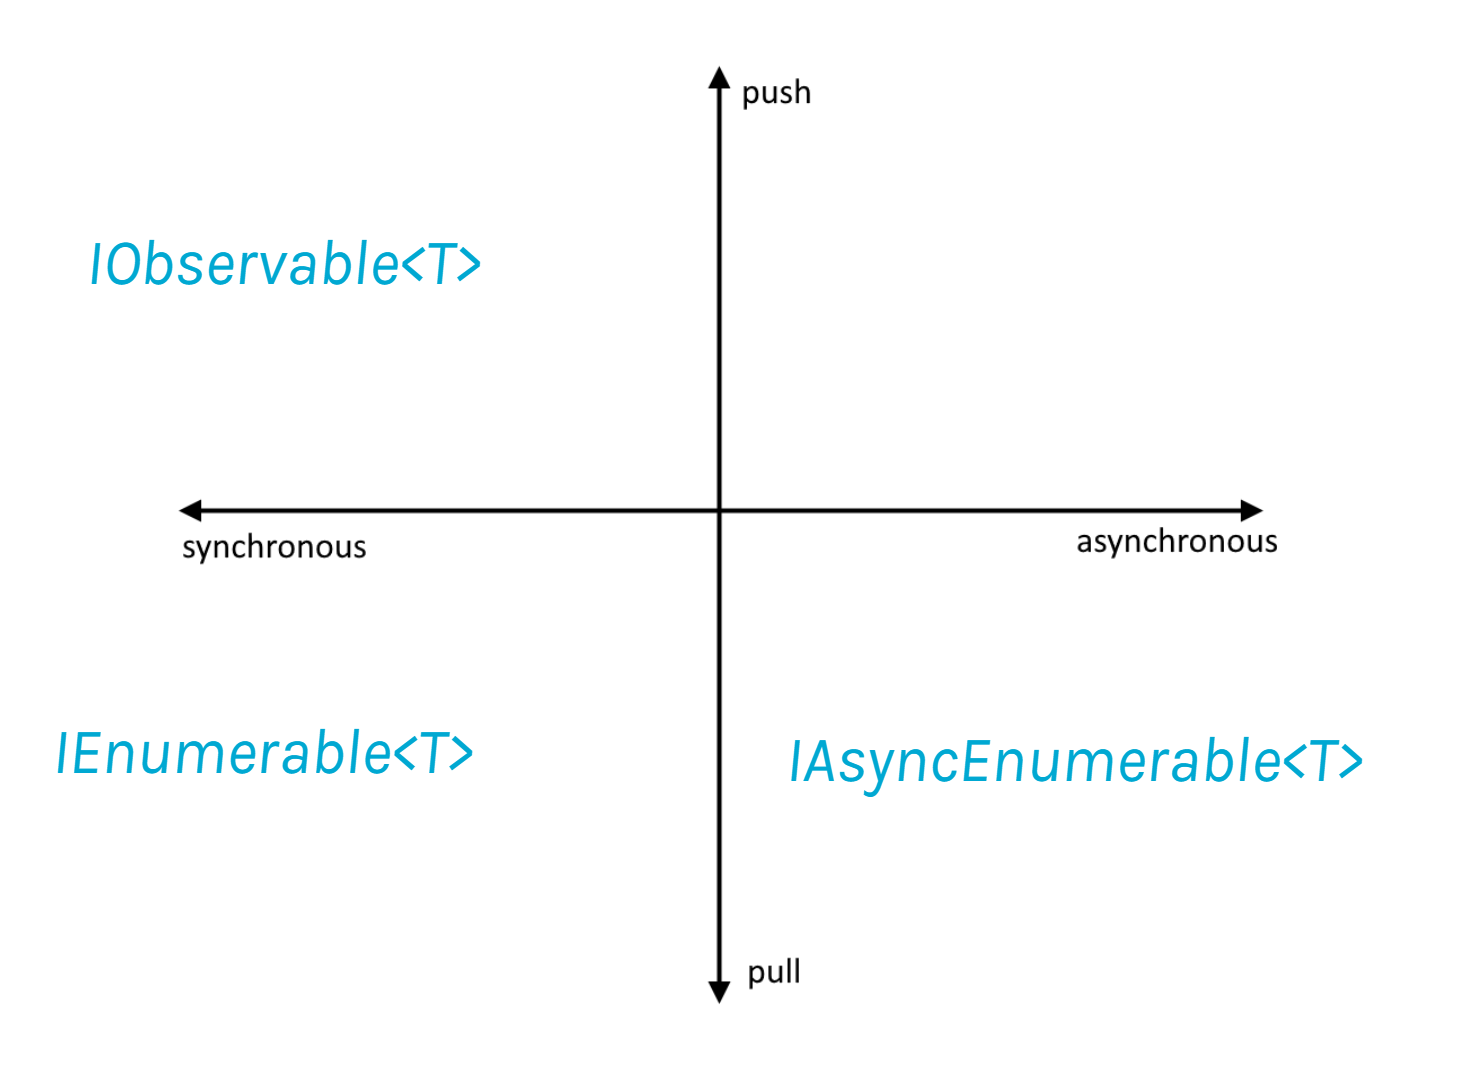
![async-prism](./async-prism.png)



## Demo

`samples\projects\get-enumerator-foreach`

## Reference

- <https://www.youtube.com/watch?v=ys2SrUel1aY&feature=youtu.be&ab_channel=DotNext>
- https://docs.microsoft.com/en-us/dotnet/api/?term=System.Collections.Generic.IAsyncEnumerable
- https://www.nuget.org/packages/Microsoft.Bcl.AsyncInterfaces/1.1.1
- <https://stu.dev/iasyncenumerable-introduction/>
- <https://dotnetcoretutorials.com/2019/01/09/iasyncenumerable-in-c-8/>
- <https://docs.microsoft.com/en-us/dotnet/csharp/tutorials/generate-consume-asynchronous-stream>